In [5]:
pip install jsonlines

Note: you may need to restart the kernel to use updated packages.


In [6]:
import json
import matplotlib.pyplot as plt
import operator
import os
import jsonlines
import numpy as np
from pandas import Series

In [7]:
def obj_dict(obj):
    return obj.__dict__

def get_mentions_of_cluster(dataset, cluster_id):
    mentions = []
    for mention in dataset:
        if mention['coref_chain'] == cluster_id:
            mentions.append(mention)

    return mentions


def get_all_chains(mentions):
    clusters = {}
    for mention_dic in mentions:
        chain = mention_dic['coref_chain']
        clusters[chain] = [] if chain not in clusters else clusters[chain]
        clusters[chain].append(mention_dic)

    return clusters


def get_cluster_by_mention_num(clusters, num):
    clusters_names = []
    for cluster, doc_mention in clusters.items():
        num_of_mentions = len(doc_mention)
        if num_of_mentions == num:
            clusters_names.append(cluster)

    return clusters_names


def get_gold_within_doc(mentions):
    wd_cluster = {}
    for mention in mentions:
        chain = mention['coref_chain']
        doc = mention['doc_id']
        id_within_doc = chain + '_' + doc
        wd_cluster[id_within_doc] = [] if id_within_doc not in wd_cluster else wd_cluster[id_within_doc]
        wd_cluster[id_within_doc].append(mention)

    return wd_cluster



def get_metainfo(clusters):
    """
    print num of mentions per clusters
    :param clusters:
    :return:
    """
    dic = {}
    for cluster, doc_mention in clusters.items():
        num_of_mentions = len(doc_mention)
        dic[num_of_mentions] = dic.get(num_of_mentions, 0) + 1

    for length, num_of_clusters in sorted(dic.items()):
        print("There are {} clusters with {} mentions".format(num_of_clusters, length))

    number = dic.values()
    labels = dic.keys()

    #get_pie_chart(number, labels)

def extract_mention_text(cluster):
    mentions = []
    for mention in cluster:
        mention.append(mention['MENTION_TEXT'])
    return mentions


def get_pie_chart(values, labels):
    patches, texts = plt.pie(values, shadow=True, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.show()


def within_to_cross(within_doc_cluster):
    cross_doc = {}
    for within in within_doc_cluster:
        name = within.split('_')[0]
        if name != 'INTRA' and name != 'Singleton':
            cross_doc[name] = [] if name not in cross_doc else cross_doc[name]
            cross_doc[name].append(within)

    return cross_doc


def find_most_popular_word(clusters, within_doc_cluster):
    words = {}
    for cluster in clusters:
        mentions = within_doc_cluster[cluster]
        vocab = set()
        for mention in mentions:
            text = mention['MENTION_TEXT']
            vocab.add(text)

        for word in vocab:
            words[word] = words.get(word, 0) + 1

    most_word = max(words.items(), key=operator.itemgetter(1))
    return most_word[0], most_word[1]/len(clusters)




def get_prob(within_doc_cluster):
    cross_doc = within_to_cross(within_doc_cluster)
    length = 0
    prob = 0
    for cluster, within in cross_doc.items():
        word, coverage = find_most_popular_word(within, within_doc_cluster)
        length += len(within)
        prob += coverage * len(within)

    return prob / length

def get_distinct_mentions(mentions):
    return list(set([m['tokens_str'] for m in mentions]))


def get_mentions(all_mentions, cluster_id, doc_id=None, sent_id=None):
    mentions = []
    for mention in all_mentions:
        if mention['coref_chain'] == cluster_id and (doc_id is None or mention['doc_id']==doc_id) and (sent_id is None or mention['sent_id'] == sent_id):
            mentions.append(mention)
            
    return mentions

# Select data to explore (ECB+ or MEANTIME)

In [8]:
data = 'data/ecb/mentions'

In [9]:
with open(data + '/all_entity_gold_mentions.json', 'r') as f:
    entity_mentions = json.load(f)

with open(data + '/all_event_gold_mentions.json', 'r') as f:
    event_mentions = json.load(f)
    
print('{} entity mentions'.format(len(entity_mentions)))
print('{} event mentions'.format(len(event_mentions)))

8289 entity mentions
6833 event mentions


In [10]:
event_cross_clusters = get_all_chains(event_mentions)
event_within_clusters = get_gold_within_doc(event_mentions)
entity_cross_clusters = get_all_chains(entity_mentions)
entity_within_clusters = get_gold_within_doc(entity_mentions)

print('Event Cross chains: {}'.format(len(event_cross_clusters)))
print('Event Within chains: {}'.format(len(event_within_clusters)))

print('Entity Cross chains: {}'.format(len(entity_cross_clusters)))
print('Entity Within chains: {}'.format(len(entity_within_clusters)))

Event Cross chains: 2741
Event Within chains: 5496
Entity Cross chains: 2221
Entity Within chains: 5850


In [6]:
entity_singleton = sum([1 for m in entity_mentions if m["coref_chain"].startswith('Singleton')])
event_singleton =  sum([1 for m in event_mentions if m["coref_chain"].startswith('Singleton')])
print('Number of entity singleton: {}'.format(entity_singleton))
print('Number of event singleton: {}'.format(event_singleton))

Number of entity singleton: 1231
Number of event singleton: 1775


In [8]:
get_mentions(entity_mentions, 'NON16190758645925671', '3_1ecbplus.xml', 5)

[{'cluster_desc': 't3_van',
  'coref_chain': 'NON16190758645925671',
  'doc_id': '3_1ecbplus.xml',
  'event_entity': 'entity',
  'full_sentence': "Comeaux , 49 , took the officers' weapons and handcuffed them together in the back of the vehicle before fleeing on foot at around 9 a . m . , Lyons said .",
  'is_pronoun': False,
  'left_sentence': "Comeaux , 49 , took the officers' weapons and handcuffed them together in the back of the",
  'm_id': '72',
  'mention_type': 'NON',
  'right_sentence': 'before fleeing on foot at around 9 a . m . , Lyons said .',
  'sent_id': 5,
  'subtopic': '3ecb+',
  'tags': [],
  'tokens_number': [17],
  'tokens_str': 'vehicle',
  'topic': '3'},
 {'cluster_desc': 't3_van',
  'coref_chain': 'NON16190758645925671',
  'doc_id': '3_1ecbplus.xml',
  'event_entity': 'entity',
  'full_sentence': "Comeaux , 49 , took the officers' weapons and handcuffed them together in the back of the vehicle before fleeing on foot at around 9 a . m . , Lyons said .",
  'is_prono

In [10]:
for mention in entity_mentions:
    if len(mention['tokens_str'].split(' ')) > 6:
        print(mention['tokens_str'])

the Betty Ford Clinic in Rancho Mirage , Calif
Betty Ford Center in Rancho Mirage , Calif .
Early Friday morning , around 1 : 30 a . m
Morningside Recovery in Newport Beach , Calif
the Promises Treatment Center in Malibu , California
a rehab facility in Malibu , Calif
Betty Ford Treatment Center in Palm Springs
into Promises Treatment Center in Los Angeles , California
on Tuesday , December 9 , 2008
Betty Ford Center in Rancho Mirage , Calif
Early Friday morning , around 1 : 30 a . m
Morningside Recovery in Newport Beach , CA
8 : 00 am local time ( 0300 GMT ) on Sunday
Shortly after 3 : 30 Tuesday morning
the Waitrose supermarket in Wellington town centre
the Waitrose supermarket in Wellington , Somerset
a Waitrose Store in High Street , Banstead
outside his house in a gang-plagued section of the city
in the East Flatbush neighborhood in Brooklyn , New York
in the East Flatbush neighborhood in Brooklyn , New York
on the Persian Gulf island of Qeshm off Iran's southern coast
an island o

# Explore filtering methods (container, MINA, head ...)

In [112]:
def plot_histogram(array):
    arr = Series(array)
    counter = arr.value_counts()
    counter.plot(kind='bar')

with open(os.path.join(data, 'clean_mentions.json'), 'r') as f:
    clean_mentions = json.load(f)

### 1. All mentions

Average length of mentions: 3.10258199581298
Max mention: 35


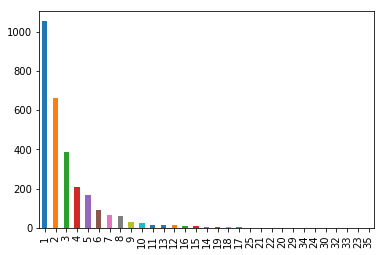

In [113]:
total_mentions = [len(m['tokens_number']) for m in entity_mentions]
plot_histogram(total_mentions)

print('Average length of mentions: {}'.format(np.mean(total_mentions)))
print('Max mention: {}'.format(max(total_mentions)))

### 2. Removing "container" mentions

225 mentions to be removed
Average length of mentions: 2.673987126088603
Max mention: 35


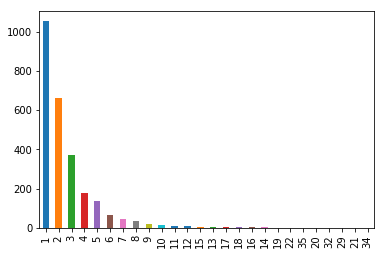

In [114]:
clean = [len(m['tokens_number']) for m in clean_mentions]
plot_histogram(clean)

print('{} mentions to be removed'.format(len(entity_mentions) - len(clean)))
print('Average length of mentions: {}'.format(np.mean(clean)))
print('Max mention: {}'.format(max(clean)))

### 3. Run MINA algorithm to minimize the mentions
#### Using constitency tree from AllenNLP, matched subtree for only 1873 mentions (71%) (See next for more details)
#### MINA found different span for 624 mentions

Average length of mentions: 2.17796289284362
Max mention: 35


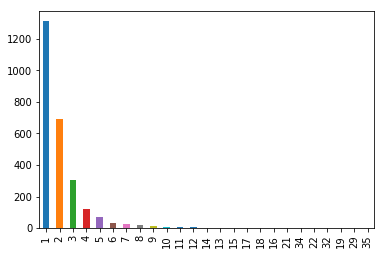

In [115]:
mina_mentions = []
modified_spans = 0
for m in clean_mentions:
    if m['min_spans']:
        mina_mentions.append(len(m['min_spans']))
    else:
        mina_mentions.append(len(m['tokens_number']))
        
plot_histogram(mina_mentions)
print('Average length of mentions: {}'.format(np.mean(mina_mentions)))
print('Max mention: {}'.format(max(mina_mentions)))

### 4. Fine-Tune MINA algorithm to cover more mentions

# Statistics on the mentions length

In [7]:
import math

def get_min_max(mentions):
    max = 0
    min = math.inf
    avg = 0
    for mention in mentions:
        length = len(mention['tokens_number'])
        avg += length
        if length > max:
            max = length
        if length < min:
            min = length
            
    return min, max, avg/len(mentions)


def mention_by_length(mentions, length):
    output = []
    for mention in mentions:
        if len(mention['tokens_number']) == length:
           output.append(mention)
        
    return output

In [8]:
print('Entity:')
min_entity, max_entity, avg_entity = get_min_max(entity_mentions)
print("The minimum mention contains {} tokens".format(min_entity))
print("The maximum mention contains {} tokens".format(max_entity))
print("The average length of mention is {} tokens".format(avg_entity))

print()
print('Event:')
min_event, max_event, avg_event = get_min_max(event_mentions)
print("The minimum mention contains {} tokens".format(min_event))
print("The maximum mention contains {} tokens".format(max_event))
print("The average length of mention is {} tokens".format(avg_event))


Entity:
The minimum mention contains 1 tokens
The maximum mention contains 35 tokens
The average length of mention is 3.10258199581298 tokens

Event:
The minimum mention contains 1 tokens
The maximum mention contains 5 tokens
The average length of mention is 1.0612244897959184 tokens


# Explore dominant mention method

In [9]:
import operator

def extract_dominant_mention(cluster_id, entity=True):
    clusters = entity_cross_clusters if entity else event_cross_clusters
    mentions = {}
    different_docs = set()
    for m in clusters[cluster_id]:
        tokens = m['tokens_str']
        mentions[tokens] = set() if tokens not in mentions else mentions[tokens]
        mentions[tokens].add(m['doc_id'])
        different_docs.add(m['doc_id'])
    
    for m, docs in mentions.items():
        mentions[m] = len(docs)
    
    most_dominant = max(mentions.items(), key=operator.itemgetter(1))
    return most_dominant[0], most_dominant[1], len(different_docs), most_dominant[1]/len(different_docs)


def compute_statistics(entity=True, weight_avg=False):
    clusters = entity_cross_clusters if entity else event_cross_clusters
    numerator = 0
    denominator = 0
    exact = 0
    dominant_mentions = []
    num_of_docs = len(set(c for c, mentions in clusters.items() if len(mentions) > 1))
    for cluster_id, mentions in clusters.items():
        if len(mentions) > 1: #don't consider Singletons in this statistics
            dominant, num, total_doc, percentage = extract_dominant_mention(cluster_id, entity)
            dominant_mentions.append(dominant)
            if weight_avg:
                numerator += percentage * len(mentions)
                denominator += len(mentions)
            else:
                numerator += percentage
                denominator += 1
            
            if percentage == 1:
                exact += 1
    ambiguity = 1 - len(set(dominant_mentions)) / len(dominant_mentions)
    return numerator/denominator, exact/num_of_docs, ambiguity


In [11]:
dominant, num, total_doc, percentage = extract_dominant_mention('HUM16236184328979740')
print("Dominant mention: {}".format(dominant))
print("Appear in {} documents on {}, percentage: {}".format(num, total_doc, percentage))

KeyError: 'HUM16236184328979740'

In [12]:
stat_entity, all_docs_entity, ambiguity_entity = compute_statistics(weight_avg=False)
stat_entity_weight, all_docs_entity_weigh, ambiguity_entity_weight = compute_statistics(weight_avg=True)
stat_event, all_docs_event, ambiguity_event = compute_statistics(entity=False, weight_avg=False)
stat_event_weight, all_docs_event_weight, ambiguity_event_weight = compute_statistics(entity=False, weight_avg=True)

print("Entity: \nNumber of document on average: {}, \nWeight average: {}, \nAmbiguity {}\nAll docs: {}".
      format(stat_entity, stat_entity_weight, ambiguity_entity, all_docs_entity))
print()
print("Event: \nNumber of document on average: {}, \nWeight average: {}, \nAmbiguity {}\nAll docs: {}".
      format(stat_event, stat_event_weight, ambiguity_event, all_docs_event))

Entity: 
Number of document on average: 0.8827528560443786, 
Weight average: 0.8044596106766753, 
Ambiguity 0.061764705882352944
All docs: 0.7529411764705882

Event: 
Number of document on average: 0.9788732394366197, 
Weight average: 0.9747899159663865, 
Ambiguity 0.21126760563380287
All docs: 0.9577464788732394


# How many clusters are actually across multiple documents

In [11]:
event_cross_doc_clusters = {}
entity_cross_doc_clusters = {}

for chain, mentions in entity_cross_clusters.items():
    docs = list(set([m['doc_id'] for m in mentions]))
    if len(docs) > 1:
        entity_cross_doc_clusters[chain] = {'num_of_docs': len(docs), 'num_of_mentions': len(mentions)}

for chain, mentions in event_cross_clusters.items():
    docs = list(set([m['doc_id'] for m in mentions]))
    if len(docs) > 1:
        event_cross_doc_clusters[chain] = {'num_of_docs': len(docs), 'num_of_mentions': len(mentions)}

print('Entity - Number of clusters across multiple documents: {} on {}'.
      format(len(entity_cross_doc_clusters), len(entity_cross_clusters)))

print('Event - Number of clusters across multiple documents: {} on {}'.
      format(len(event_cross_doc_clusters), len(event_cross_clusters)))

Entity - Number of clusters across multiple documents: 702 on 2221
Event - Number of clusters across multiple documents: 669 on 2741
